In [21]:
import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

This is a summary of the work on on June 20th and 21st. 

First I shifted the Model to have the same zero as the Data. It must be noted that I did not take into account the envelope function assuming the effects would be small enough that they could be ignored. 

I then ran the same MCMC test and got the following numbers from the resulting corner plots and histograms.

Means
z_not:  0.000157881588507
q:  21.3790525768
p:  0.0146442984523
T:  0.00795999628391

A:  2.16095251255e-05

Peaks
z_not:  0.000157881588507
q:  22.5
p:  .01399
T:  .00173
A:  .0000

Using the numbers from TimeConstant3 I checked to see the differences in the Model's convolved versus deconvolved spectrum.

This is what is shown below.

Mira

In [22]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import pickle
import seaborn as sns
import sys
import numpy as np
import scipy.optimize as op
from scipy.optimize import curve_fit

sns.set_palette("PuBuGn_d",15)
sns.set_style("whitegrid")
import emcee

In [23]:
with open('../../../data/raw_data/20170615_1729_30mms_reference.pkl', 'rb') as f:
    d = pickle.load(f, encoding='latin1') 

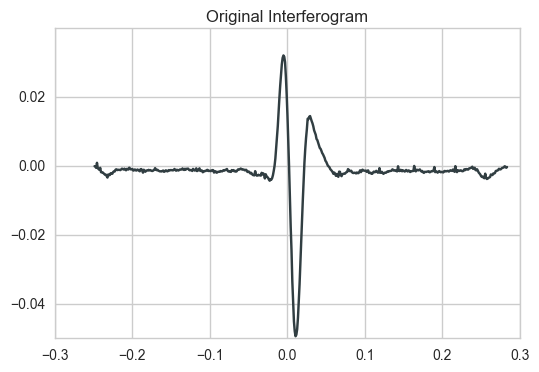

In [24]:
i = 9
Nsize = 2**i
dt=(1/(d['sample freq'])) #period
T1=dt*(Nsize) #full period
v=(d['speed'])
X = v*T1 #full distance
dx = dt*v #smallest amount of distance travelled
total_t = (d['scan time']) #how long it ran
    
total_s = (d['samples requested']) #number of samples 
startpt = ((total_s - Nsize)/2) #starting point


endpt = startpt + Nsize #ending point
startpt = int(startpt)
endpt = int(endpt)


df = 1/T1
f = df*np.arange(Nsize/2)+df/2.0
fFull = df*np.arange((Nsize/2) + 1)+df/2.0


F = (d['sig0F']) 
D = F[startpt:endpt]
#D = np.flipud(D)

a = d['delay0F']/v
t = a[startpt:endpt]

pl.plot(t,D)
pl.title('Original Interferogram')
pl.show()

In [25]:
#model function convoluted with RC circuit and AC coupling function
def psi1(znot,q,p,T):
    Ns = Nsize
    z = t
    dz = z[2]-z[1]
    f = np.linspace(0,0.5/dz, np.floor(Ns/2))
    f_full = np.linspace(0,0.5/dz, np.floor(Ns/2) +1)
    #original function
    y0=-np.cos(2*np.pi*q*(z-znot))*(np.exp(-((z-znot)**2)/(2*p**2)))/(np.sqrt(2*np.pi)*p)
    yf0=np.fft.rfft(y0)
    K_det =(1/(1+(1j*2*np.pi*f_full*T))) #kernel from detector
    K_cc =(2*np.pi*f_full*.559)/(1 + (1j*2*np.pi*.559)) #kernel from AC coupling
    K_f = np.multiply(K_det,K_cc)
    y1=np.fft.irfft(yf0*K_f*2*np.pi)
    return t,y1
#znot = 0.012, q = 8.57718120805, p = .04

In [26]:
#likelihood function
#why is it ln?
def lnlike(params, t, D):
    znot, q, p, T, a = params 
    t,Modelf = psi1(znot,q,p, T)
    Dev = -.5*(np.dot((D-(Modelf*a-.00148)),D-(Modelf*a-.00148)))
    Sig=0.0005
    return (Dev/Sig)-np.log(1/Sig) #sigma? if sigma is large it becomes shallower

In [27]:
nll = lambda *args: -lnlike(*args) 
result = op.minimize(nll, [.003,23.51,0.01335,0.0028, .00001], args=(t,D))
znot1,q1,p1,T1,a1 = result["x"]

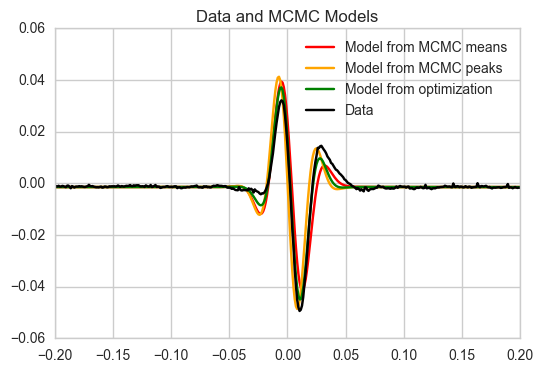

In [28]:
x2,Modelf2 = psi1( 0.000157881588507,   21.3790525768,   0.0146442984523,   .00795999628391) #z,q,p,T
pl.plot(x2,Modelf2*2.16095251255e-05-.00148, label = 'Model from MCMC means', color = 'red')

x3,Modelf3 = psi1( 0.000157881588507,   22.5,   0.01399,   .00173) #z,q,p,T
pl.plot(x3,Modelf3*.000014-.00148, label = 'Model from MCMC peaks', color = 'orange')

x1,Modelf1 = psi1( 4.08117518e-03,   1.97816983e+01,   1.32568793e-02,   5.79709697e-05) #z,q,p,T
pl.plot(x1,Modelf1*1.32596339e-05-.00148, label = 'Model from optimization', color = 'green')

pl.plot(t,D, label = 'Data', color = 'black')

pl.xlim(-.2,.2)
pl.title('Data and MCMC Models')
pl.legend()
pl.show()

It is important to note that the model function used was reached mathematically and not due to instrumentation. Therefore it will not be perfect. This is to explain how all of these methods lead to slightly different constants and time constants.

Using the numbers from the MCMC here I will deconvolve the Model function.
that is to say the time constant is set to .00173, the peak of the time constant.

The amplitudes have been adjusted to make the differences more clear.

/Users/Lab/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


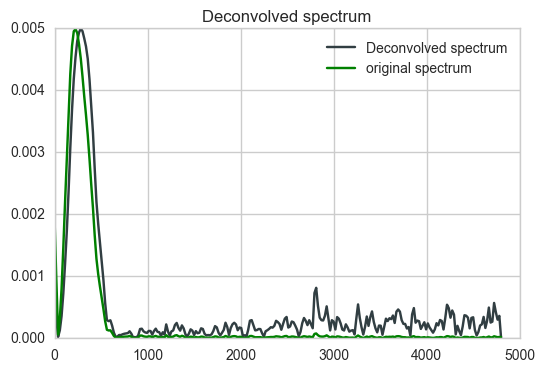

In [33]:
A = np.hanning(Nsize)*F[startpt:endpt]
S = np.fft.rfft(A)
s = S[:-1]
u = np.abs(s)
dNu = 1/(Nsize*dx)
Nu = dNu*np.arange(Nsize/2)
NuFull = dNu*np.arange((Nsize/2) + 1)
center = (300*(Nu[0] + Nu[-1]))/2
top = max(np.abs(s))
tau = 0.0017 #ms
k_v = 1/((1/tau)+1j*2*np.pi*300*NuFull)
            
            
n = 3 #greater number filters out more high frequencies
sig = n/(tau*(2*np.pi)) 
f = (1/(sig*np.sqrt(np.pi)))*np.exp(-(NuFull**2)/(sig**2)) #gaussian
B = f*np.fft.rfft(A)/k_v*tau  #fourier transform of interferogram/kernel
c = np.fft.irfft(B) #inverse fourier transform of deconvolved spectrum (deconvolved interferogram)
            
# normalize gaussian to get rid of noise (divide by integral of itself) (in B)
            
g = (np.abs(np.fft.rfft(c))/k_v*tau)[:2**7] #CHANGE depending on number of data points
L=np.sum(g) #integral of spectrum
            
xint, yint = t, (1/L)*c
xspec, yspec = 300*NuFull, np.abs(np.fft.rfft(c))/k_v*tau
pl.plot(xspec,yspec, label = 'Deconvolved spectrum')
pl.plot(300*NuFull,np.abs(S)*.00575, label = 'original spectrum', color = 'green')
pl.title('Deconvolved spectrum')
pl.legend()
pl.show()

/Users/Lab/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


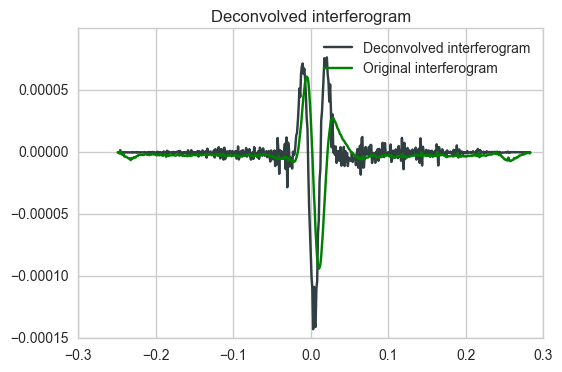

In [30]:
pl.plot(xint,yint, label = 'Deconvolved interferogram')
pl.plot(t,D*.0019, label = 'Original interferogram', color = 'green')
pl.title('Deconvolved interferogram')
pl.legend()